In [1]:
import annoy
import tabulate
import random

from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from joblib import dump, load

### Divide data

In [2]:
unknown = pd.read_csv("test_unknown.csv")

train_known = pd.read_csv("train.csv")
test_known = pd.read_csv("test_known.csv")
train_unknown, test_unknown = train_test_split(unknown, test_size=0.8, random_state=42)



X_train_known, Y_train_known = train_known.drop(["class"], axis=1).values, train_known["class"].values

X_train_unknown, Y_train_unknown = train_unknown.drop(["class"], axis=1).values, train_unknown["class"].values

X_test_known, Y_test_known = test_known.drop(["class"], axis=1).values, test_known["class"].values

X_test_unknown, Y_test_unknown = test_unknown.drop(["class"], axis=1).values, test_unknown["class"].values



contamination = len(X_train_unknown)/(len(X_train_unknown) + len(X_train_known))

### Outlier detector "Local Outlier Factor". Tune parameter

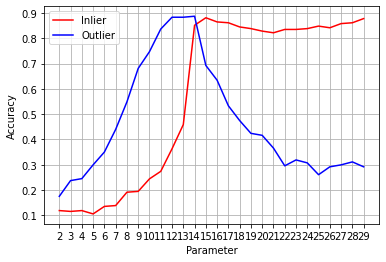

In [3]:
inlier_accuracies = []
outlier_accuracies = []

parameter_range = range(2, 30)

for k in parameter_range:
    clf = LocalOutlierFactor(
        n_neighbors=k,
        novelty=True,
        contamination=contamination
    )
    clf.fit(np.vstack((X_train_known, X_train_unknown)))
    
    outlier_predict_known = clf.predict(X_test_known)
    outlier_predict_unknown = clf.predict(X_test_unknown)
    
    inlier_accuracies.append(outlier_predict_known[outlier_predict_known == 1].size/outlier_predict_known.size)
    outlier_accuracies.append(outlier_predict_unknown[outlier_predict_unknown == -1].size/outlier_predict_unknown.size)
    
plt.plot(parameter_range, inlier_accuracies, 'r', label="Inlier")
plt.plot(parameter_range, outlier_accuracies, 'b', label="Outlier")
plt.xticks(parameter_range)
plt.xlabel("Parameter")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

We choose 14 as the number of neighbors

## Training

In [4]:
# Global variables

vector_length = X_train_known.shape[1]
metric = "angular"
LOF_name="loftest1"
Annoy_name="annoytest1"
n_neighbors=14

### Local Outlier Factor

In [5]:
def LOF_model_training(n_neighbors, LOF_name):

    clf = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            novelty=True,
            contamination=contamination
        )

    clf.fit( np.vstack((X_train_known, X_train_unknown)) )
    
    dump(clf, '{}.joblib'.format(LOF_name)) 

### Classification Annoy Trees

In [6]:
def Annoy_model_training(Ntrees, N_nearest_neighbors,Annoy_name):

    Nsamples = X_train_known.shape[0]

    t = annoy.AnnoyIndex(vector_length,metric=metric)
    
    for i, v in enumerate(X_train_known):
        t.add_item(i, v)
        
    t.build(Ntrees)
    
    t.save('{}.ann'.format(Annoy_name))

### Create models

In [7]:
LOF_model_training(n_neighbors,LOF_name=LOF_name)
Annoy_model_training(Ntrees=10,N_nearest_neighbors=5,Annoy_name=Annoy_name)

## Pipeline

### Load

In [8]:
def load_models():
    clf = load('{}.joblib'.format(LOF_name)) 
    u = annoy.AnnoyIndex(vector_length, metric=metric)
    u.load('{}.ann'.format(Annoy_name))
    
    return clf, u

### Single person

In [9]:
def single_person_classification(subject,annoy_model,lof_model):
    
    out_or_in = lof_model.predict(subject.reshape(1, -1))
        
    if out_or_in == -1:
        result = -1
    elif out_or_in == 1:
        result = Y_train_known[annoy_model.get_nns_by_vector(subject, 5,include_distances=False)[0]]
                               
    return result

### Testing

In [16]:
def testing():
   
    clf, u = load_models()
    
    # Known subjects
    
    known_prediction = []
    
    for subject in X_test_known:
        known_prediction.append(single_person_classification(subject,annoy_model=u,lof_model=clf))
        
    unknown_prediction = []
    
    for subject in X_test_unknown:
        unknown_prediction.append(single_person_classification(subject,annoy_model=u,lof_model=clf))
        
    print("Unknown accuracy score: ", accuracy_score(Y_test_unknown,unknown_prediction)*100,"%")
    print("Known accuracy score:   ", accuracy_score(Y_test_known,known_prediction)*100,"%")

In [17]:
testing()

Unknown accuracy score:  88.715953307393 %
Known accuracy score:    83.82838283828383 %
